### Cell 1: Setup & Data Ingestion  
Load necessary libraries, configure paths, and read in all raw call-data CSV files.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob as glob
import re
from pathlib import Path
import math
import io
import imageio

In [3]:
DATA_DIR = Path("/Users/staspupkov/Documents/24-25/Spring 25/DSCI410/CAD_data_through_2025")
FILE_PATTERN = "class_data_*.csv"
EXPANSION_DATE = pd.Timestamp("2017-01-01 05:00")

In [4]:
# Plot styling
sns.set_theme(style="whitegrid", font_scale=1.1)

In [5]:
# Discover & load
files = sorted(DATA_DIR.glob(FILE_PATTERN))
print(f"Found {len(files)} CSV files in {DATA_DIR}")
dfs = [
    pd.read_csv(f, parse_dates=["calltime"], low_memory=False)
    for f in files
]
master_df = pd.concat(dfs, ignore_index=True)

Found 12 CSV files in /Users/staspupkov/Documents/24-25/Spring 25/DSCI410/CAD_data_through_2025


In [9]:
master_df.to_csv("/Users/staspupkov/Documents/24-25/Spring 25/DSCI410/masterdf")

In [8]:
print("Master DF shape:", master_df.shape)
master_df.head(3)

Master DF shape: (1488577, 20)


yr service   inci_id            calltime case_id callsource  \
0  2014    LAW   14000001 2014-01-01 00:00:05     NaN       SELF   
1  2014    LAW   14000003 2014-01-01 00:01:50     NaN       SELF   
2  2014    LAW   14000006 2014-01-01 00:05:17     NaN      PHONE   

         nature closecode                        closed_as  secs_to_disp  \
0  TRAFFIC STOP      UTC   UNIFORM TRAFFIC CITATION ISSUED           1.0   
1  TRAFFIC STOP      ADVI                          ADVISED           0.0   
2       DISPUTE      ADVI                          ADVISED         219.0   

   secs_to_arrv  secs_to_close  disp  arrv  beat priority    zip primeunit  \
0           1.0            690     1     1  EP05        6  97402    5Z51     
1           0.0            170     1     1  EP02        6  97401    5T82     
2         596.0           1444     1     1  EP01        3  97401    5E93     

   units_dispd  units_arrived  
0            1              1  
1            2              2  
2            3              2

In [9]:
# Parse timestamps & flag pre/post expansion
master_df = master_df.copy()

In [10]:
# Parse with coercion & count errors
parsed = pd.to_datetime(master_df['calltime'], errors='coerce')
n_bad   = parsed.isna().sum()
print(f"Dropped {n_bad} rows due to unparseable timestamps.")
master_df['calltime'] = parsed
master_df = master_df.dropna(subset=['calltime'])

Dropped 0 rows due to unparseable timestamps.


In [11]:
# Extract temporal features
master_df['date']           = master_df['calltime'].dt.date
master_df['hour']           = master_df['calltime'].dt.hour
master_df['month']          = master_df['calltime'].dt.month
master_df['post_expansion'] = master_df['calltime'] >= EXPANSION_DATE

master_df.head(3)

yr service   inci_id            calltime case_id callsource  \
0  2014    LAW   14000001 2014-01-01 00:00:05     NaN       SELF   
1  2014    LAW   14000003 2014-01-01 00:01:50     NaN       SELF   
2  2014    LAW   14000006 2014-01-01 00:05:17     NaN      PHONE   

         nature closecode                        closed_as  secs_to_disp  ...  \
0  TRAFFIC STOP      UTC   UNIFORM TRAFFIC CITATION ISSUED           1.0  ...   
1  TRAFFIC STOP      ADVI                          ADVISED           0.0  ...   
2       DISPUTE      ADVI                          ADVISED         219.0  ...   

   beat  priority    zip  primeunit units_dispd units_arrived        date  \
0  EP05         6  97402     5Z51             1             1  2014-01-01   
1  EP02         6  97401     5T82             2             2  2014-01-01   
2  EP01         3  97401     5E93             3             2  2014-01-01   

  hour  month  post_expansion  
0    0      1           False  
1    0      1           False  
2    0      1           False  

[3 rows x 24 columns]

In [12]:
cahoots_pattern = re.compile(
    r'^(1J77|3J79|3J78|4J79|3J81|3J76|2J28|2J29|CAHOOTS?|CAHOT)$',
    flags=re.IGNORECASE
)

def classify_unit(call_sign):
    """
    Return 'CAHOOTS' if call_sign matches one of the known CAHOOTS unit codes,
    'unknown' if null, else 'NOT CAHOOTS'.
    """
    if pd.isna(call_sign):
        return "unknown"
    cs = call_sign.strip()
    return "CAHOOTS" if cahoots_pattern.fullmatch(cs) else "NOT CAHOOTS"

In [13]:
# Apply to your primeunit (or whichever column holds the unit call-sign)
master_df['Unit Type'] = master_df['primeunit'].apply(classify_unit)

In [17]:
# Quick sanity check: how many of each?
print(master_df['Unit Type'].value_counts(dropna=False))

Unit Type
NOT CAHOOTS    950511
unknown        355485
CAHOOTS        182581
Name: count, dtype: int64


In [18]:
print(master_df['calltime'].dtype)

datetime64[ns]


In [19]:
daily = (
    master_df
      # only include known responders if you like:
      .loc[master_df['Unit Type'].isin(['CAHOOTS','NOT CAHOOTS'])]
      .groupby(['date','Unit Type'])
      .size()
      .unstack(fill_value=0)         # zero where no calls on that day
)

In [20]:
# 3. Reindex to a complete date range so no gaps
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
daily = daily.reindex(full_idx, fill_value=0)
daily.index.name = 'date'

In [21]:
daily_7d = daily.rolling(window=7, center=True).mean()

In [22]:
# 4. Quick sanity-check
print("Sample daily counts:")
display(daily.head())
print("\nSample 7-day rolling averages:")
display(daily_7d.head())

Sample daily counts:


Unit Type   CAHOOTS  NOT CAHOOTS
date                            
2014-01-01       24          307
2014-01-02       21          301
2014-01-03       22          276
2014-01-04       20          234
2014-01-05       34          152


Sample 7-day rolling averages:


Unit Type     CAHOOTS  NOT CAHOOTS
date                              
2014-01-01        NaN          NaN
2014-01-02        NaN          NaN
2014-01-03        NaN          NaN
2014-01-04  24.857143   236.571429
2014-01-05  24.857143   222.000000

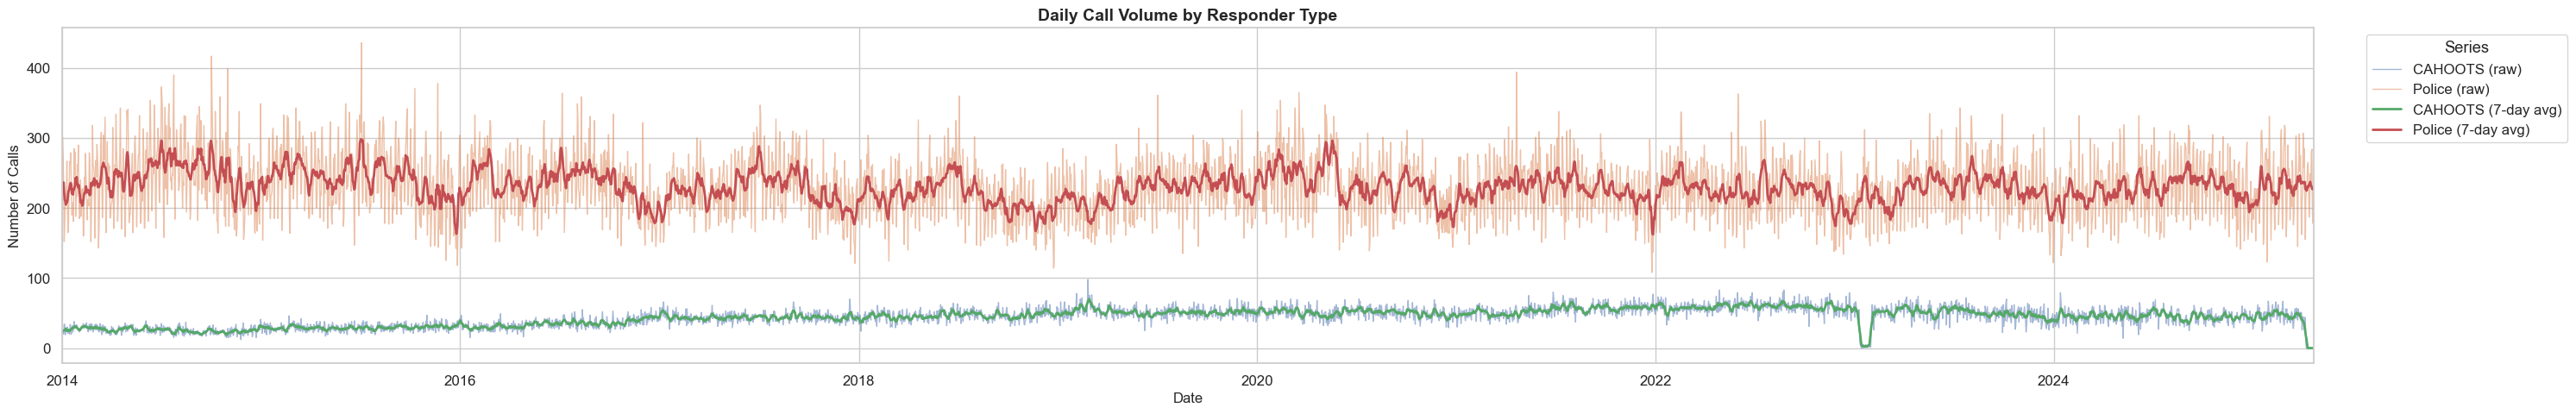

In [106]:
fig, ax = plt.subplots(figsize=(30,5))

# raw daily counts
daily.plot(ax=ax, alpha=0.5, linewidth=1)

# 7-day rolling mean
daily_7d.plot(ax=ax, linewidth=2)

# labels & legend
ax.set_title("Daily Call Volume by Responder Type", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Calls", fontsize=12)
ax.legend(
    ['CAHOOTS (raw)', 'Police (raw)',
     'CAHOOTS (7-day avg)', 'Police (7-day avg)'],
    title="Series",
    bbox_to_anchor=(1.02, 1), loc='upper left'
)

plt.tight_layout()
plt.show()

**Raw Data**
\
Looking at the raw data above, it is hard to make out anything of significance in a quick glance. We can see that there was 0 CAHOOTS calls for a little while in 2023? What is that all about?

#### Classify Incident Natures & Filter to CAHOOTS-Dominant
We’ll define “CAHOOTS-dominant” as those natures with ≥51% of calls handled by CAHOOTS and at least 10 total calls.

In [71]:
master_df['nature_clean'] = (
    master_df['nature']
    .str.upper()              # ensure consistent uppercase
    .str.strip()              # remove leading/trailing whitespace
    .str.replace(r',\s*CAHOOTS$', '', regex=True)  # drop any ", CAHOOTS" suffix
)

In [73]:
core = master_df.copy()

In [74]:
# 1. Pivot counts by nature & responder
pivot = (
    core
    .groupby(['nature_clean','Unit Type'])
    .size()
    .unstack(fill_value=0)
)

for col in ['CAHOOTS','NOT CAHOOTS']:
    pivot[col] = pivot.get(col, 0)

In [77]:
pivot['total']        = pivot['CAHOOTS'] + pivot['NOT CAHOOTS']
pivot['share_cahoots']= pivot['CAHOOTS'] / pivot['total']

In [79]:
min_total     = 10      # drop natures with fewer than this many total calls
mostly_thresh = 0.51    # CAHOOTS share threshold for “Mostly CAHOOTS”
even_thresh   = 0.20    # lower bound for “Roughly Even”

In [81]:
conds = [
    pivot['total'] < min_total,
    pivot['share_cahoots'] >= mostly_thresh,
    pivot['share_cahoots'].between(even_thresh, mostly_thresh, inclusive='left'),
    pivot['share_cahoots'] < even_thresh,
]
choices = [np.nan, 'Mostly CAHOOTS', 'Roughly Even', 'Mostly NOT CAHOOTS']

In [83]:
pivot['class'] = np.select(conds, choices)

In [85]:
class_dict = (
    pivot
    .reset_index()
    .dropna(subset=['class'])
    .groupby('class')['nature_clean']
    .agg(list)
    .to_dict()
)

In [87]:
mostly_cahoots = class_dict.get('Mostly CAHOOTS', [])
even_natures    = class_dict.get('Roughly Even', [])
not_cahoots     = class_dict.get('Mostly NOT CAHOOTS', [])
print(f"Mostly CAHOOTS ({len(mostly_cahoots)}):\n", mostly_cahoots, "\n")
print(f"Roughly Even ({len(even_natures)}):\n", even_natures, "\n")
print(f"Mostly NOT CAHOOTS ({len(not_cahoots)}):\n", not_cahoots, "\n")

Mostly CAHOOTS (14):
 ['ASSIST FD', 'ASSIST PD', 'ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'DEATH MESSAGE', 'DISORIENTED SUBJECT', 'EMERGENCY MESSAGE', 'FOUND SYRINGE', 'INFO / ATL', 'INTOXICATED SUBJECT', 'POISONING', 'PUBLIC ASSIST', 'SUICIDAL SUBJECT', 'TRANSPORT'] 

Roughly Even (4):
 ['ASSIST FIRE DEPARTMENT', 'LOST SUBJECT', 'MENTAL SUBJECT', 'SUBJECT DOWN'] 

Mostly NOT CAHOOTS (241):
 ['ABANDONED ANIMAL', 'ABANDONED BIKE', 'ABANDONED PROPERTY', 'ABANDONED VEHICLE', 'ACCIDENT BIKE', 'ACCIDENT VEHICLE BIKE', 'ALARM', 'ALARM BC ACTIVATION', 'ALARM DURESS', 'ALARM HOLD UP', 'ALARM PANIC', 'ALARM SILENT', 'ANIMAL ABUSE', 'ANIMAL AT LARGE', 'ANIMAL ATTACK/BITE', 'ANIMAL BITE', 'ANIMAL COMPLAINT', 'ANIMAL CRUELTY', 'ARMED DISPUTE', 'ARMED SUBJECT', 'ARREST', 'ARSON', 'ASSAULT', 'ASSAULT APA', 'ASSAULT WITH INJURY', 'ASSIST MOTORIST', 'ASSIST OREGON STATE POLICE', 'ASSIST OUTSIDE AGENCY', 'ASSIST PUBLIC WORKS', 'ASSIST SHERIFFS OFFICE', 'ATTEMPT TO LOCATE', 'ATTEMPT TO LOCATE DRUNK DRI

In [89]:
core['nature_clean'] = (
    core['nature_clean']
    .str.replace(r',\s*CAHOOTS$', '', regex=True)
    .str.strip()
)

In [91]:
to_drop = [
    'ASSIST PUBLIC- POLICE',
    'ASSIST FD',
    'ASSIST PD',
    'PUBLIC ASSIST',
    'TRAFFIC HAZARD',
    'TRANSPORT'
]

In [93]:
core = core[~core['nature_clean'].isin(to_drop)].copy()
print("After cleanup, unique core natures:", core['nature_clean'].unique())

After cleanup, unique core natures: ['TRAFFIC STOP' 'DISPUTE' 'THEFT' 'ILLEGAL BURNING' 'PERSON STOP' 'DWS'
 'LOUD NOISE' 'THEFT FROM VEHICLE' 'ASSAULT' 'DUII' 'MINOR IN POSSESSION'
 'CRIMINAL TRESPASS' 'ATTEMPT TO LOCATE DRUNK DRIVER'
 'ASSIST OREGON STATE POLICE' 'SUBJECT DOWN' 'LOCATE MISSING PERSON'
 'DISORDERLY SUBJECT' 'FIGHT' 'BEAT INFORMATION' 'WRONG WAY DRIVER'
 'VEHICLE/PEDESTRIAN CRASH' 'CRIMINAL MISCHIEF' 'DRUG INFO'
 'ACCIDENT BIKE' 'INTOXICATED SUBJECT' 'WATER PROBLEM' 'CHECK WELFARE'
 'DEATH MESSAGE' 'PATROL CHECK' 'INCOMPLETE CALL' 'ASSIST FIRE DEPARTMENT'
 'DISABLED VEHICLE' 'RUNAWAY JUVENILE' 'BURGLARY' 'DAMAGE CITY PROPERTY'
 'ALARM HOLD UP' 'FOUND PROPERTY' 'RECOVERED STOLEN VEHICLE'
 'RECKLESS DRIVIING' 'FOLLOW UP' 'LOST PROPERTY' 'HAZARD SAFETY'
 'THEFT OF IDENTITY' 'NATURAL GAS LEAK' 'RAPE' 'ATTEMPT TO LOCATE'
 'DISPUTE FAMILY' 'HARASSMENT' 'ABANDONED VEHICLE' 'DOG AT LARGE'
 'LOCATION STOLEN VEHICLE' 'DRIVING COMPLAINT' 'ALARM PANIC'
 'ILLEGAL CAMPING' 'SUSPICIO

In [94]:
core_cahoots_df = core[core['nature_clean'].isin(mostly_cahoots)].copy()
print("core_cahoots_df shape:", core_cahoots_df.shape)
print("Final natures:", core_cahoots_df['nature_clean'].unique())

core_cahoots_df shape: (128334, 26)
Final natures: ['INTOXICATED SUBJECT' 'CHECK WELFARE' 'DEATH MESSAGE' 'SUICIDAL SUBJECT'
 'POISONING' 'FOUND SYRINGE' 'DISORIENTED SUBJECT' 'EMERGENCY MESSAGE'
 'INFO / ATL']


### Daily Call Volume by Year (CAHOOTS-Dominant Natures)
Loop through each calendar year and plot raw daily counts + 7-day rolling mean in a simple for-loop.

In [98]:
daily_core = (
    core_cahoots_df
      .groupby(["date","Unit Type"])
      .size()
      .unstack(fill_value=0)
)
full_idx = pd.date_range(daily_core.index.min(), daily_core.index.max(), freq="D")
daily_core = daily_core.reindex(full_idx, fill_value=0)
daily_core.index.name = "date"

In [100]:
daily_core_7d = daily_core.rolling(window=7, center=True).mean()

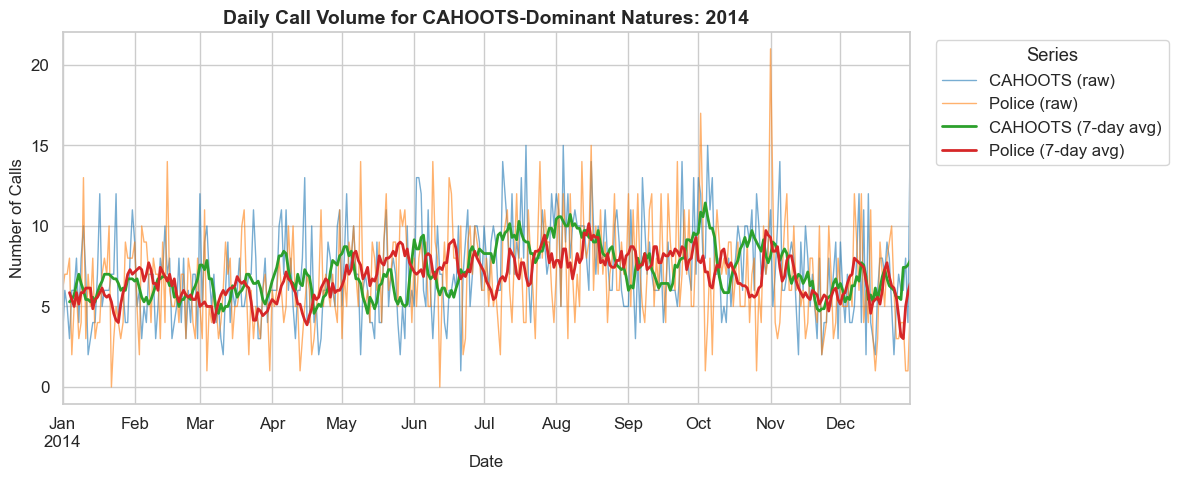

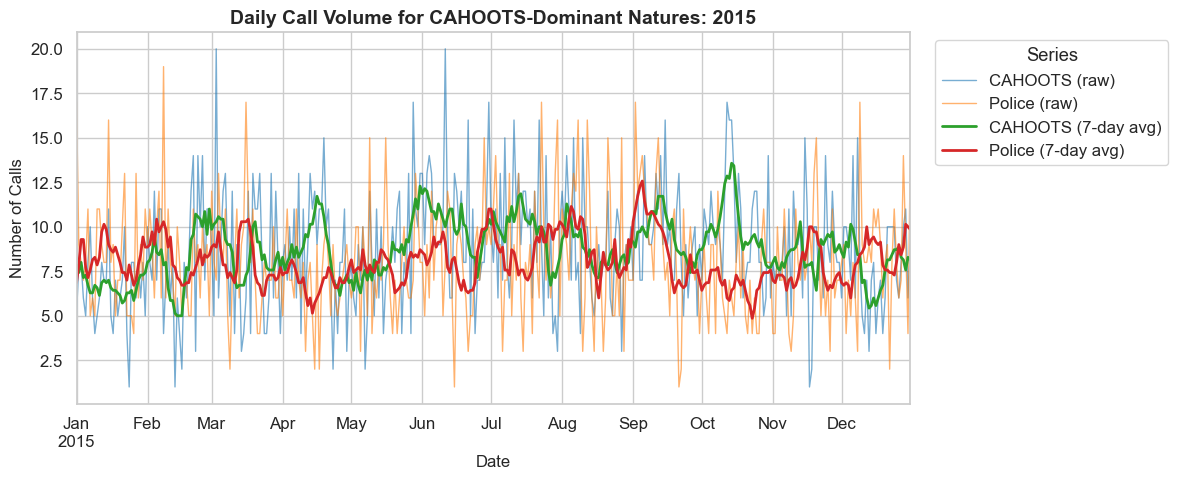

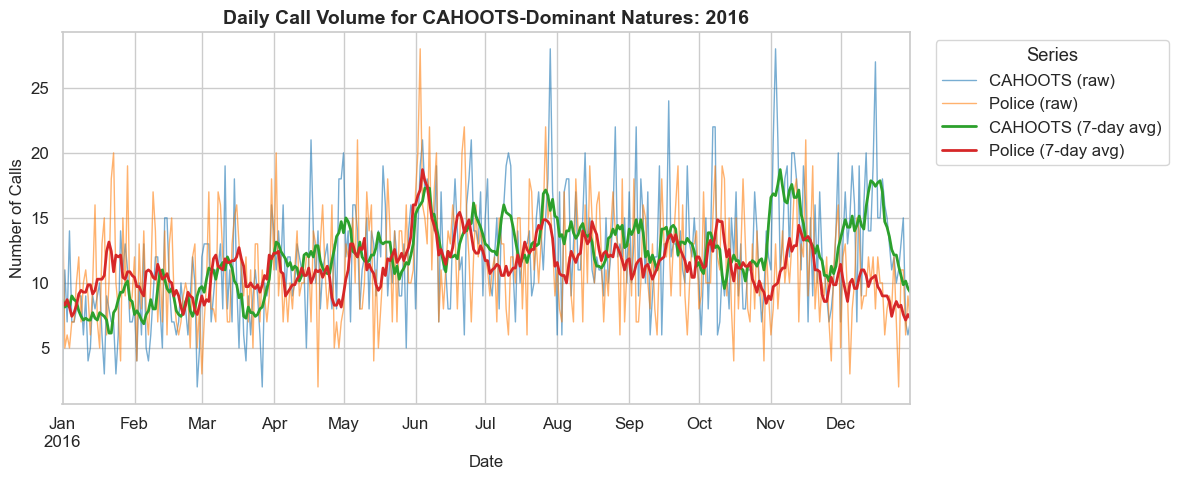

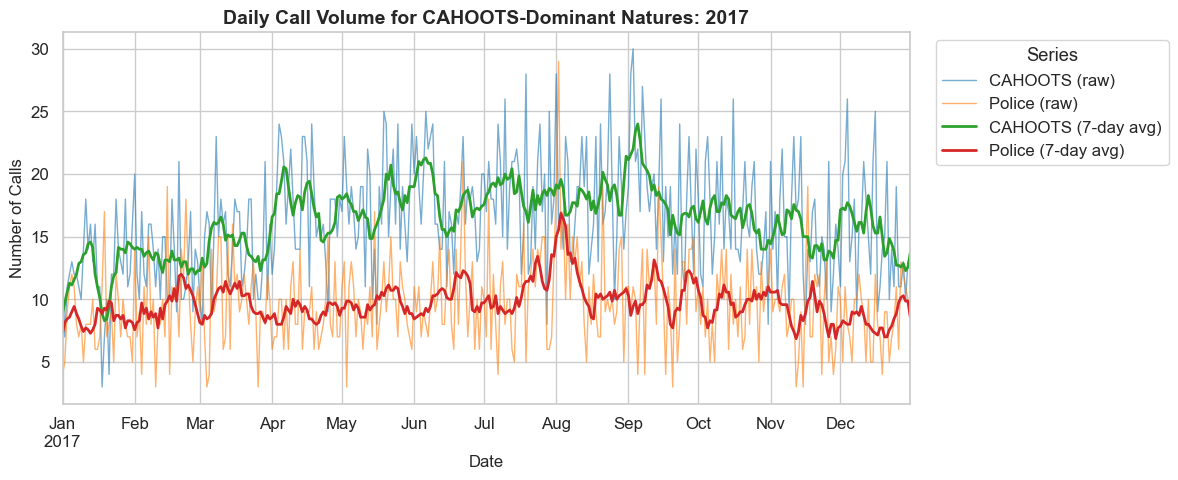

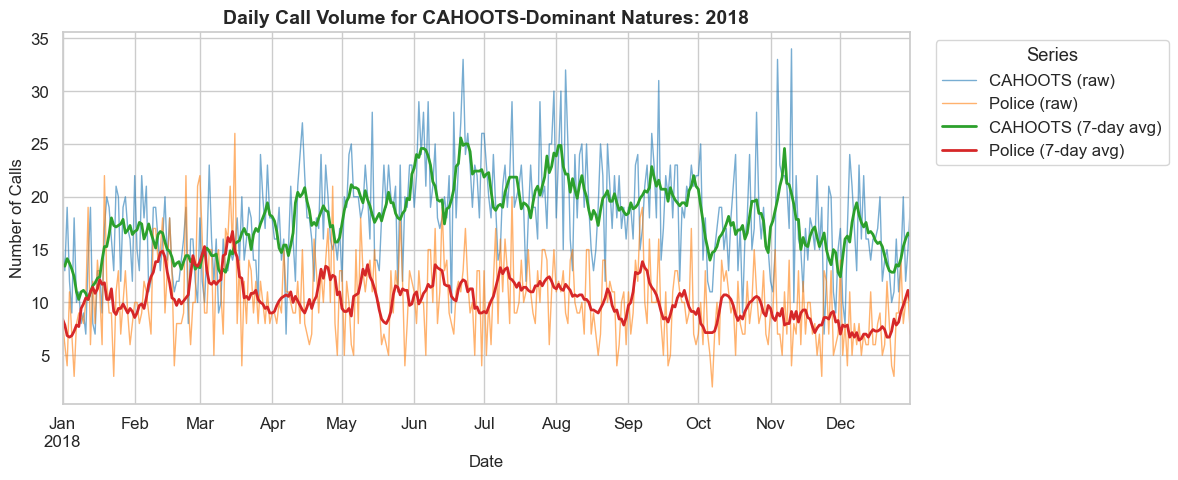

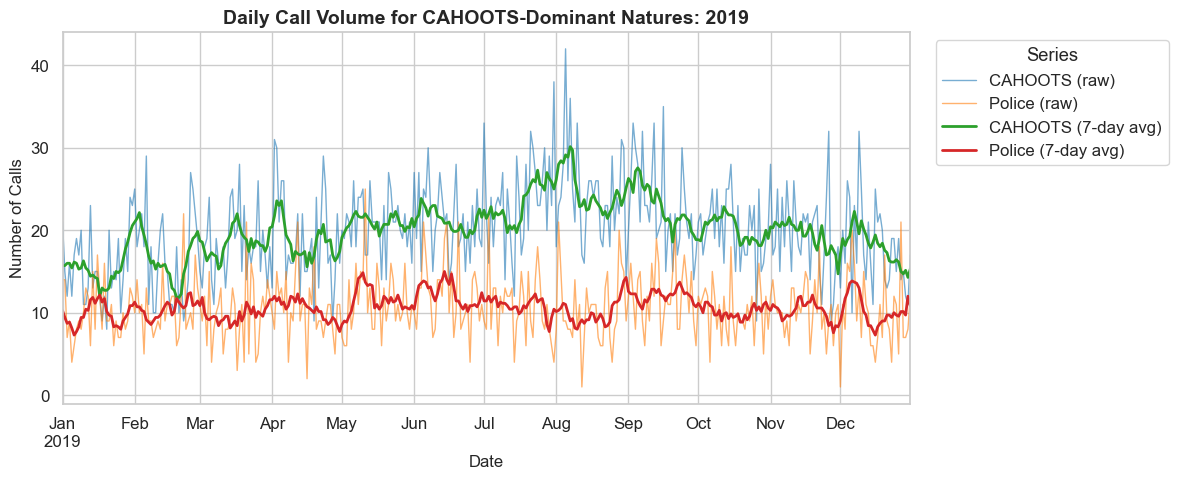

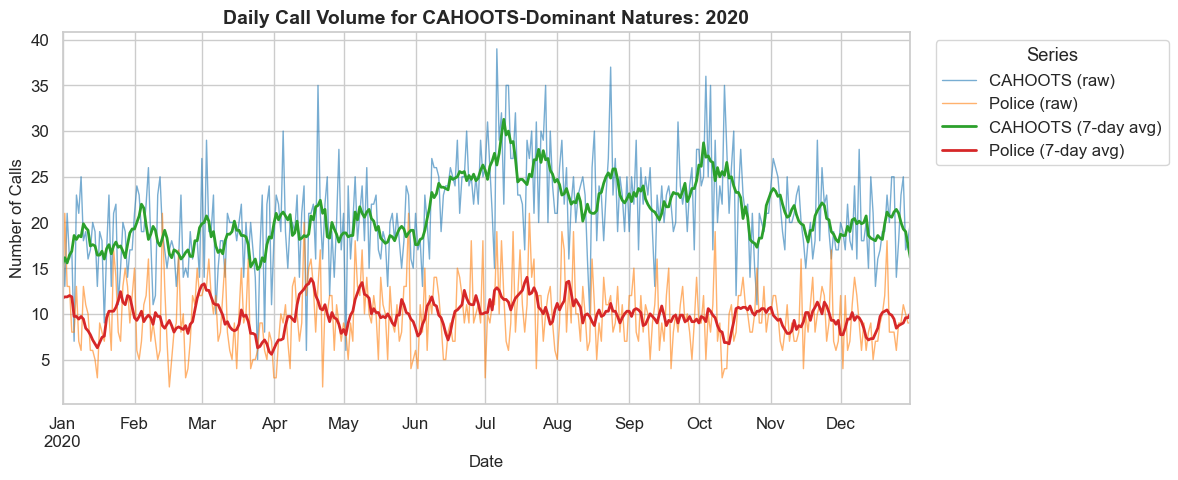

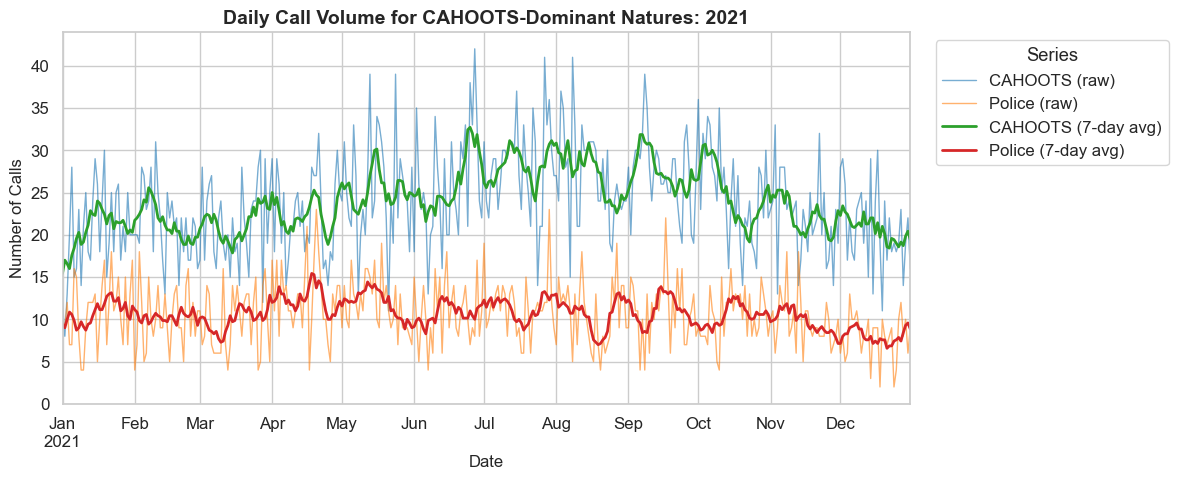

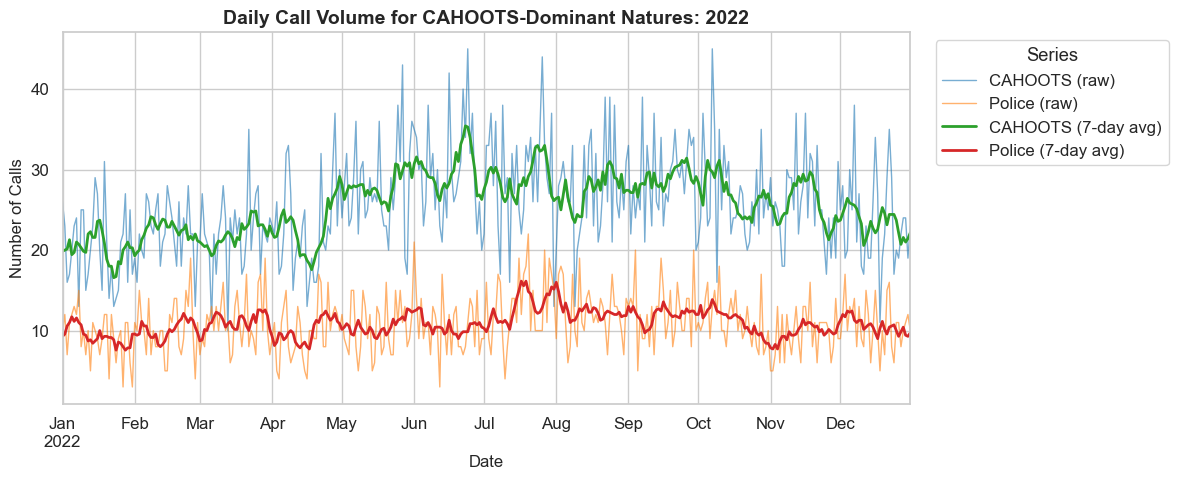

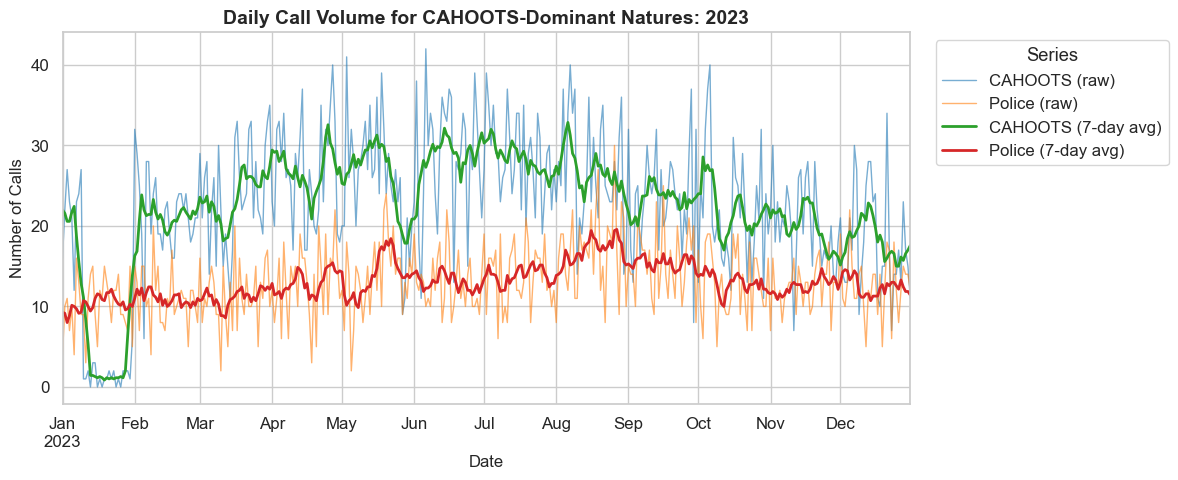

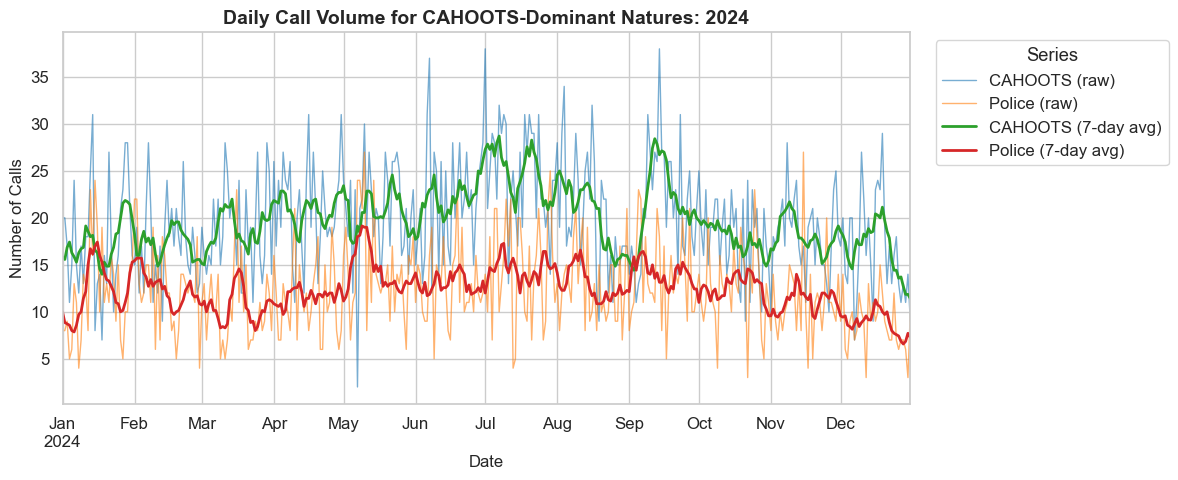

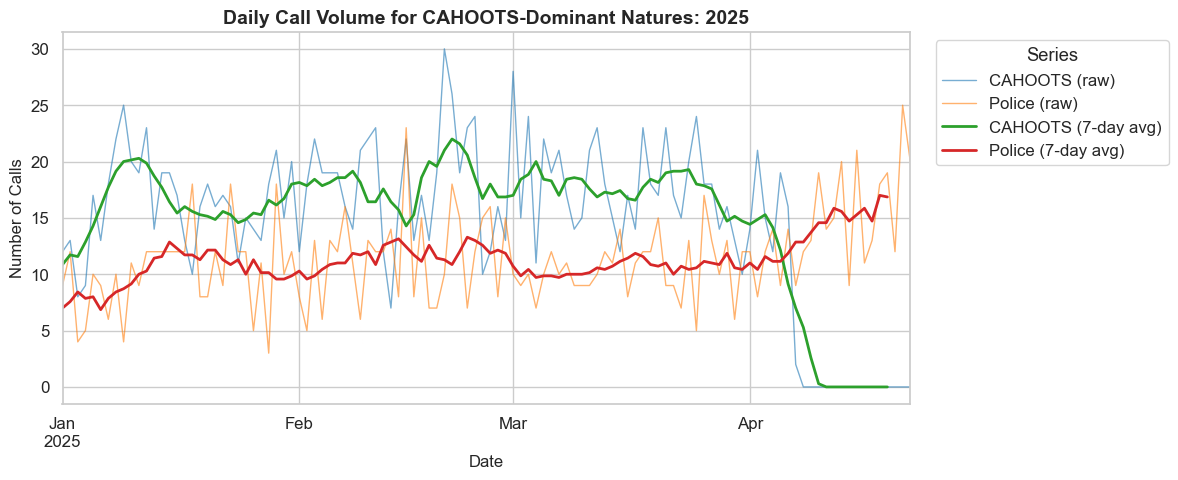

In [102]:
years = sorted(daily_core.index.year.unique())

for yr in years:
    raw    = daily_core[daily_core.index.year == yr]
    smooth = daily_core_7d[daily_core_7d.index.year == yr]
    if raw.empty:
        continue

    plt.close('all')                            # clear any old figures
    fig, ax = plt.subplots(figsize=(12, 5))     # just one subplots() call

    # 1) CAHOOTS raw
    raw['CAHOOTS'].plot(
        ax=ax, color='tab:blue', alpha=0.6, linewidth=1,
        label='CAHOOTS (raw)'
    )
    # 2) Police raw
    raw['NOT CAHOOTS'].plot(
        ax=ax, color='tab:orange', alpha=0.6, linewidth=1,
        label='Police (raw)'
    )
    # 3) CAHOOTS 7-day avg
    smooth['CAHOOTS'].plot(
        ax=ax, color='tab:green', linewidth=2,
        label='CAHOOTS (7-day avg)'
    )
    # 4) Police 7-day avg
    smooth['NOT CAHOOTS'].plot(
        ax=ax, color='tab:red', linewidth=2,
        label='Police (7-day avg)'
    )

    ax.set_title(
        f"Daily Call Volume for CAHOOTS-Dominant Natures: {yr}",
        fontsize=14, weight='bold'
    )
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Number of Calls", fontsize=12)
    ax.legend(
        title="Series", bbox_to_anchor=(1.02, 1), loc='upper left'
    )
    plt.tight_layout()
    plt.show()

### Daily Call Volume in the 3 am–10 am Window
Filter to calls between 03:00 and 10:00, aggregate by day & responder, fill gaps, compute a 7-day centered rolling mean, and plot.


In [152]:
# 1. Isolate the 3 am–10 am window
window_df = core[(core['hour'] >= 3) & (core['hour'] < 10)].copy()

In [154]:
daily_win = (
    window_df
    .groupby(['date','Unit Type'])
    .size()
    .unstack(fill_value=0)
)

In [156]:
full_idx = pd.date_range(daily_win.index.min(), daily_win.index.max(), freq='D')
daily_win = daily_win.reindex(full_idx, fill_value=0)
daily_win.index.name = 'date'

In [158]:
daily_win_7d = daily_win.rolling(window=7, center=True).mean()

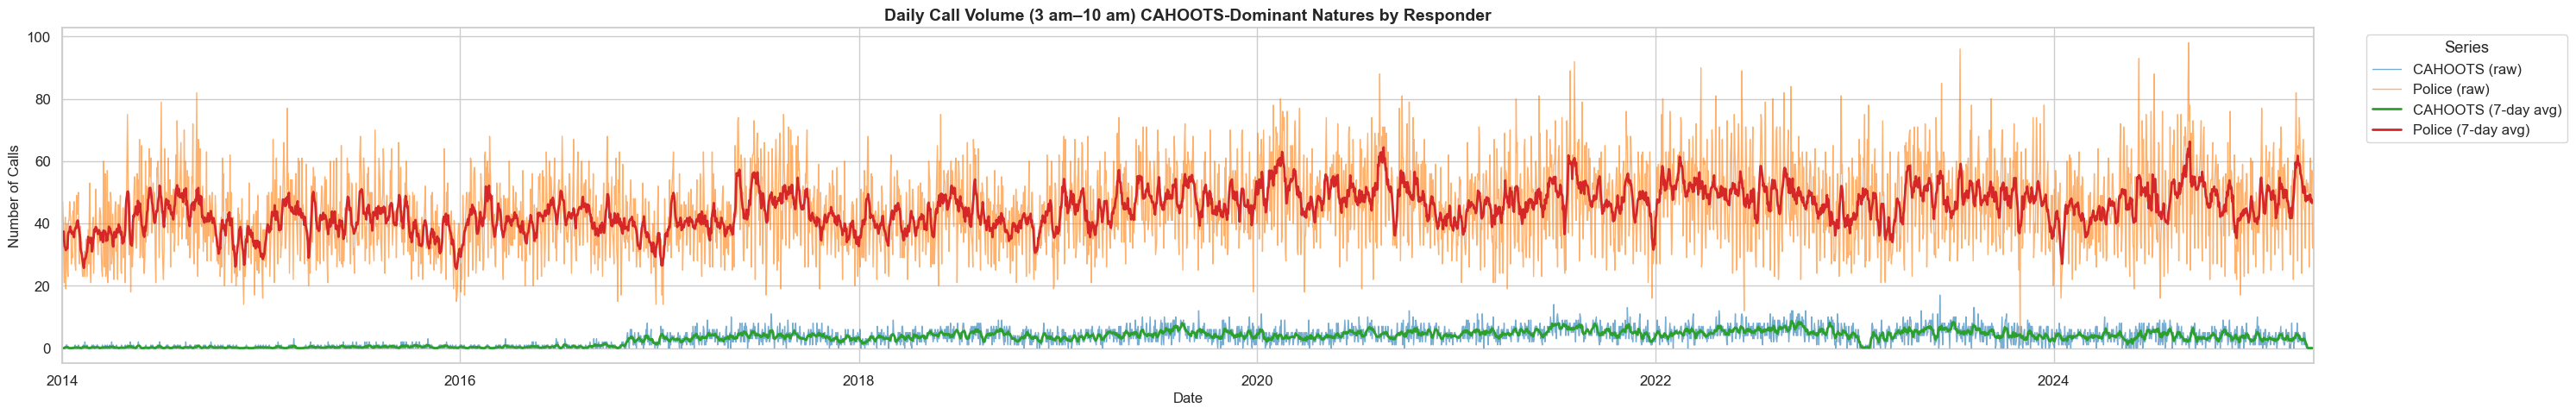

In [164]:
fig, ax = plt.subplots(figsize=(30, 5))

# raw
daily_win['CAHOOTS'].plot(ax=ax, color='tab:blue',  alpha=0.6, linewidth=1, label='CAHOOTS (raw)')
daily_win['NOT CAHOOTS'].plot(ax=ax, color='tab:orange',alpha=0.6, linewidth=1, label='Police (raw)')

# smoothed
daily_win_7d['CAHOOTS'].plot(ax=ax, color='tab:green', linewidth=2, label='CAHOOTS (7-day avg)')
daily_win_7d['NOT CAHOOTS'].plot(ax=ax, color='tab:red',   linewidth=2, label='Police (7-day avg)')

# styling
ax.set_title("Daily Call Volume (3 am–10 am) CAHOOTS-Dominant Natures by Responder", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Number of Calls", fontsize=12)
ax.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Daily Call Volume (3 am–10 am) for CAHOOTS-Dominant Natures

In [118]:
window_core = core_cahoots_df[
    (core_cahoots_df['hour'] >= 3) &
    (core_cahoots_df['hour']  < 10)
].copy()

In [120]:
daily_core_win = (
    window_core
      .groupby(['date', 'Unit Type'])
      .size()
      .unstack(fill_value=0)
)

In [122]:
full_idx = pd.date_range(daily_core_win.index.min(),
                         daily_core_win.index.max(),
                         freq='D')
daily_core_win = daily_core_win.reindex(full_idx, fill_value=0)
daily_core_win.index.name = 'date'


In [124]:
daily_core_win_7d = daily_core_win.rolling(window=7, center=True).mean()

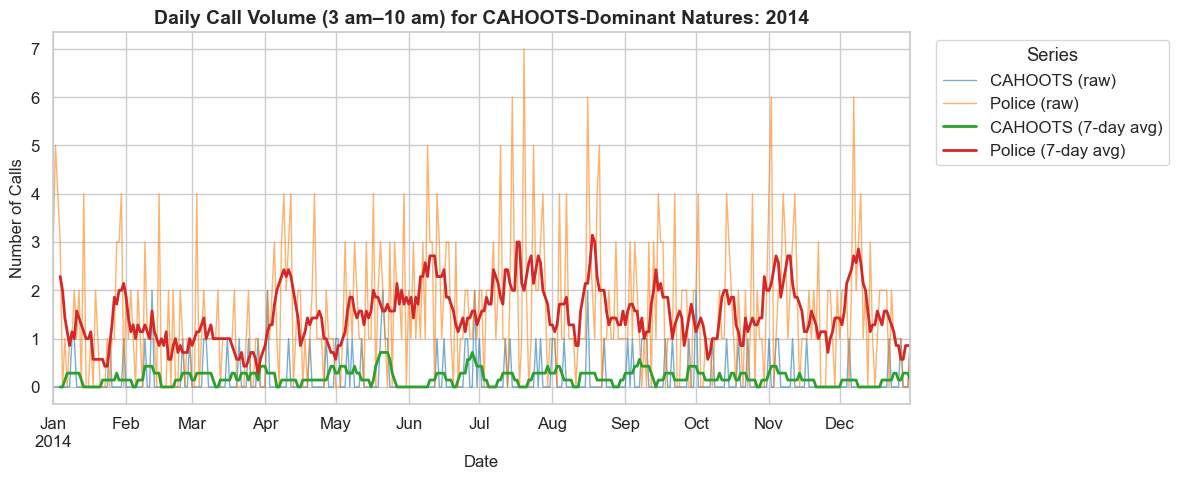

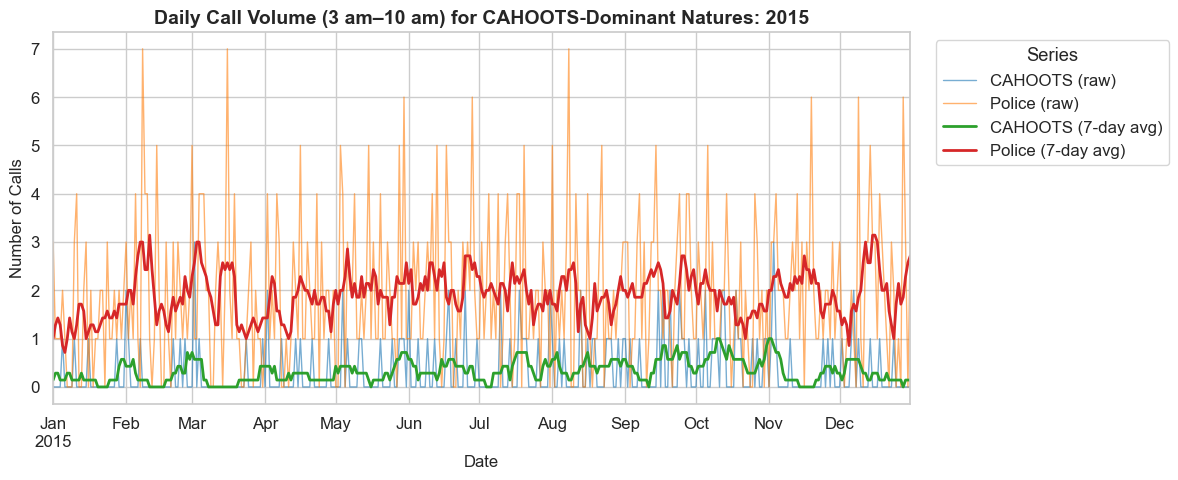

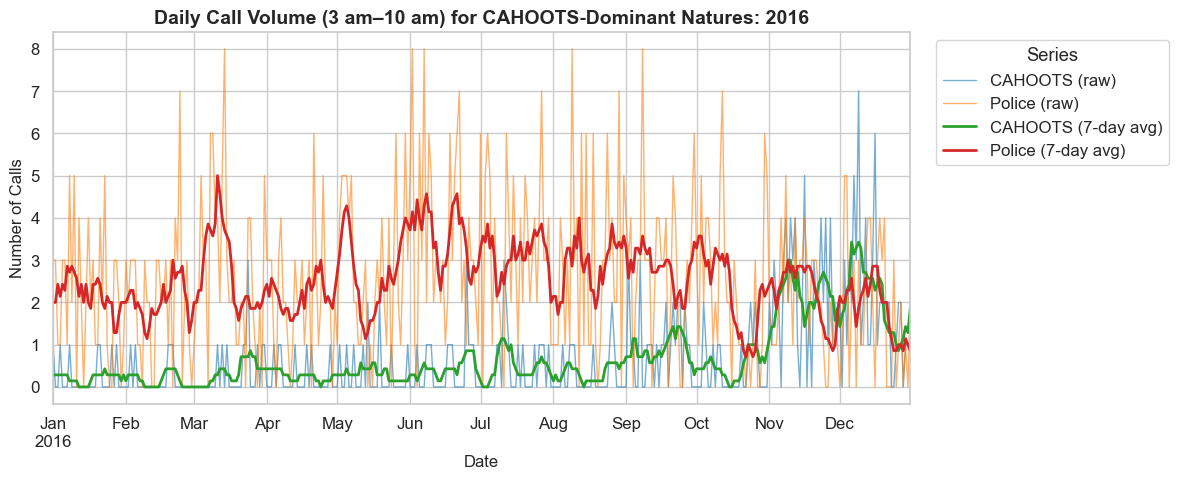

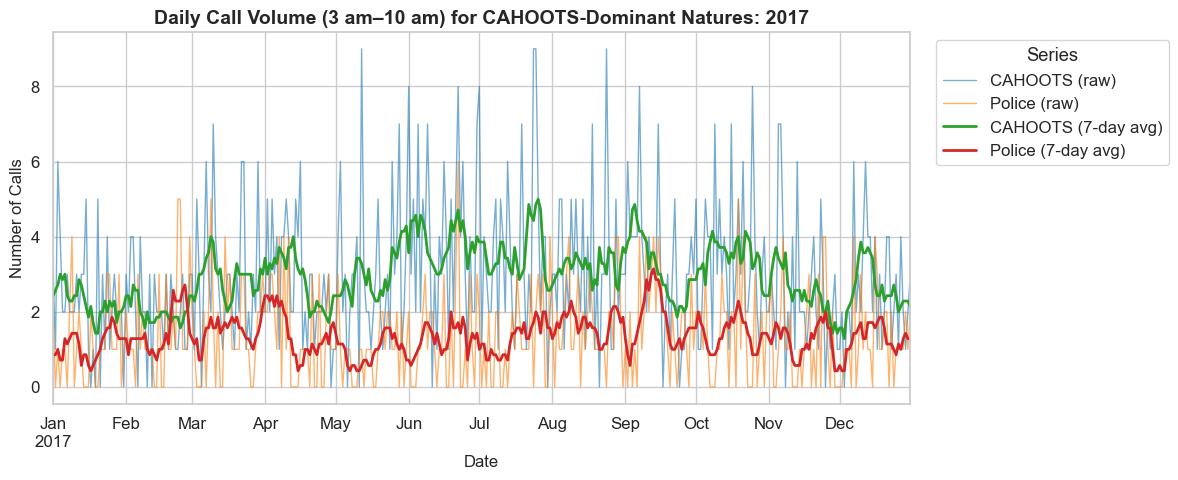

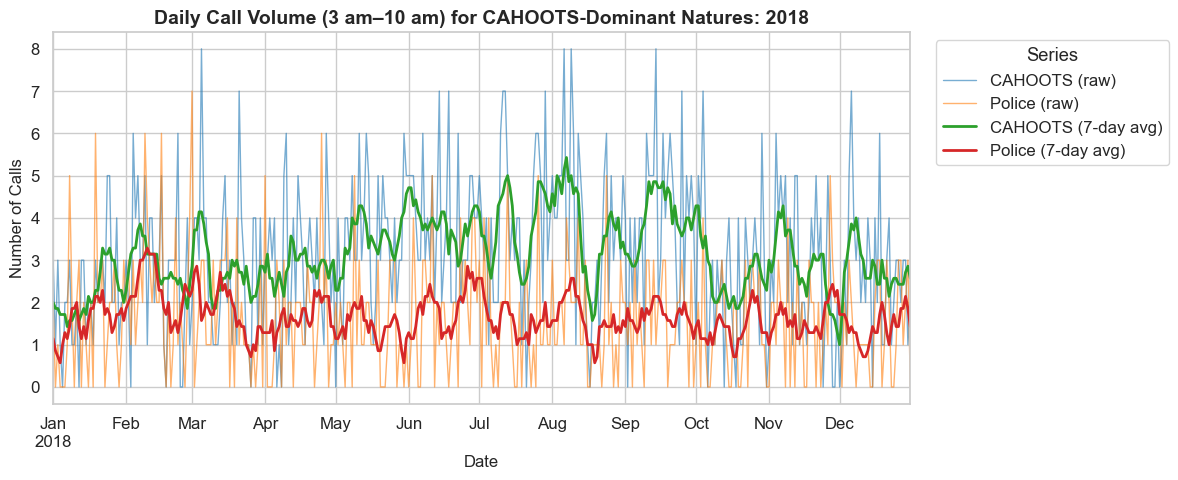

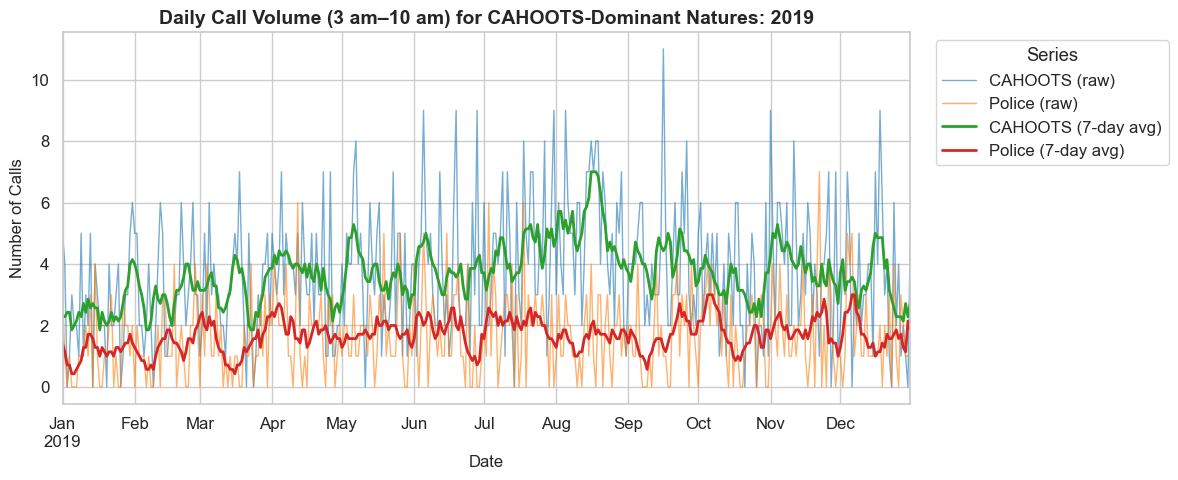

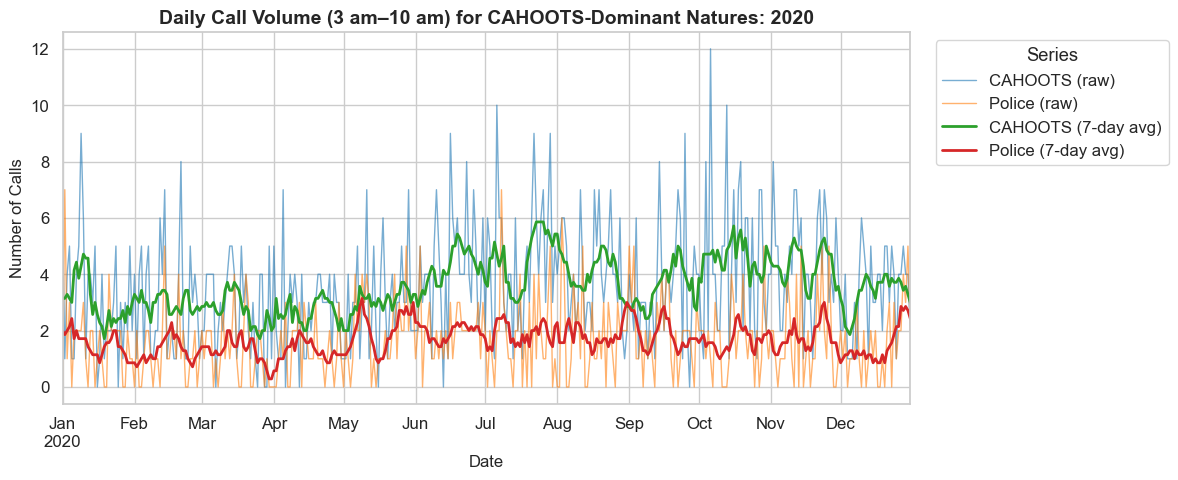

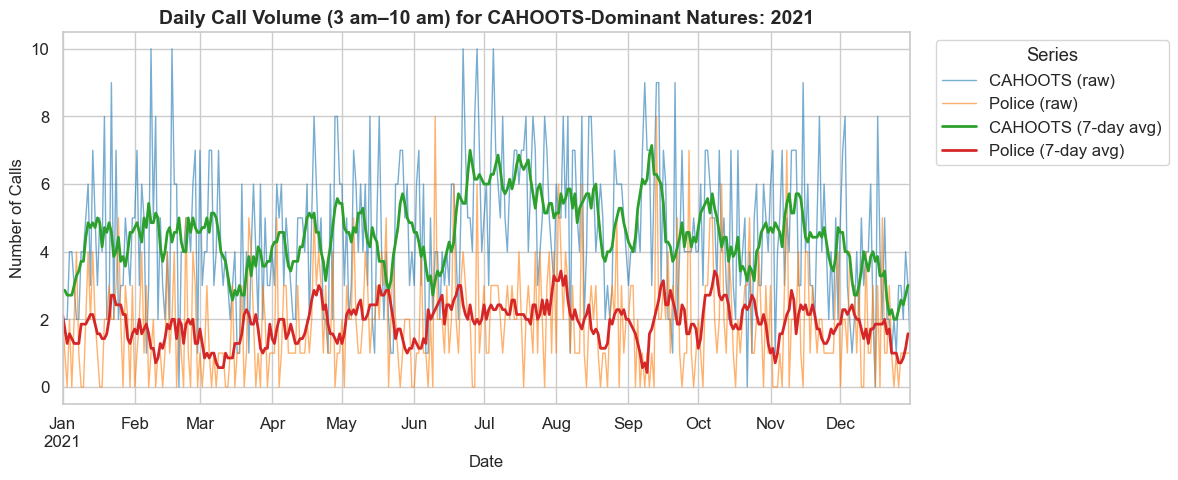

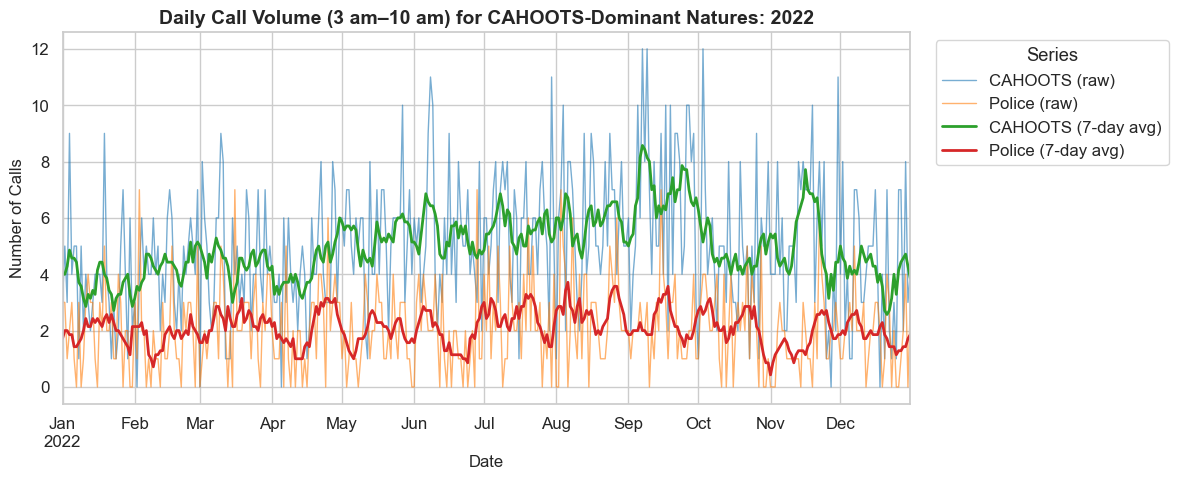

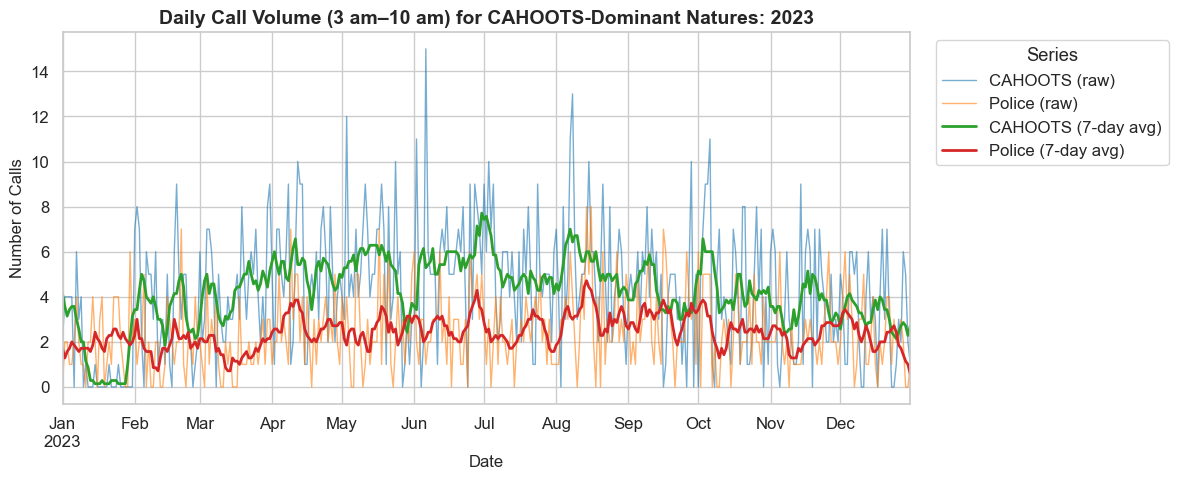

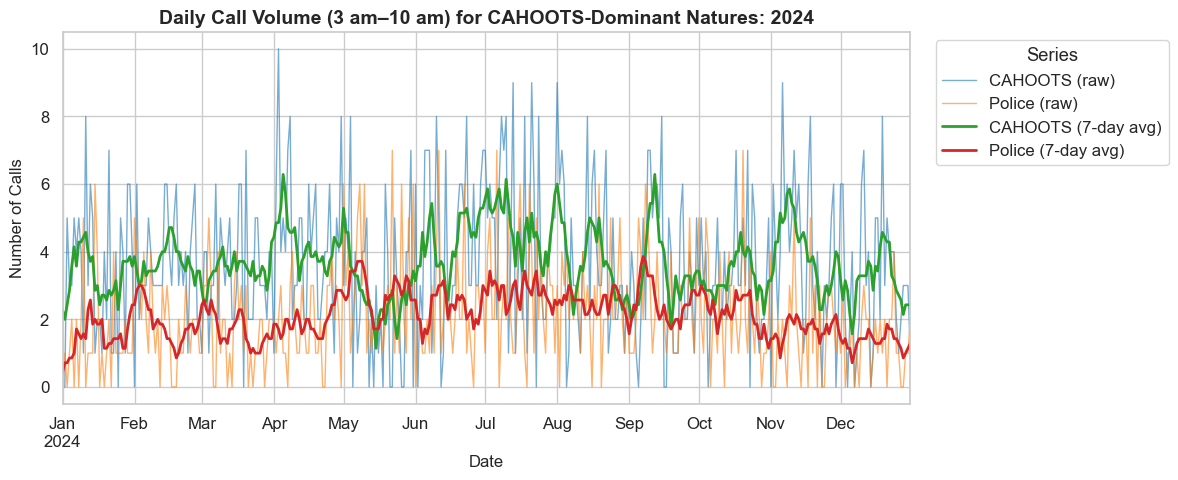

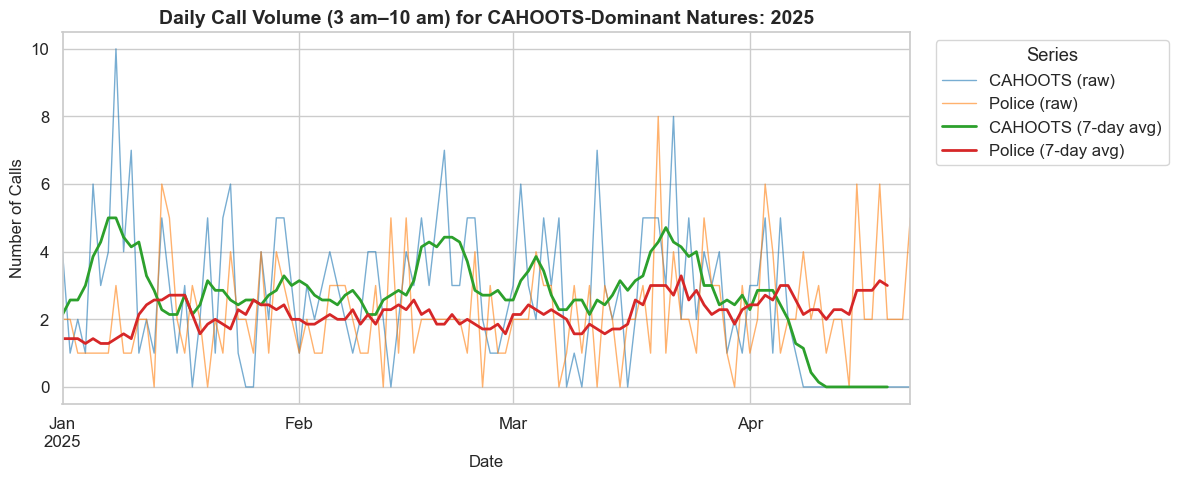

In [126]:
years = sorted(daily_core_win.index.year.unique())

for yr in years:
    # 1) slice out just this year
    raw    = daily_core_win[daily_core_win.index.year == yr]
    smooth = daily_core_win_7d[daily_core_win_7d.index.year == yr]
    if raw.empty:
        continue

    # 2) clean slate
    plt.close('all')
    fig, ax = plt.subplots(figsize=(12, 5))

    # 3) plot per‐year raw & smoothed lines
    raw['CAHOOTS'].plot(
        ax=ax, color='tab:blue',  alpha=0.6, linewidth=1,
        label='CAHOOTS (raw)'
    )
    raw['NOT CAHOOTS'].plot(
        ax=ax, color='tab:orange', alpha=0.6, linewidth=1,
        label='Police (raw)'
    )
    smooth['CAHOOTS'].plot(
        ax=ax, color='tab:green', linewidth=2,
        label='CAHOOTS (7-day avg)'
    )
    smooth['NOT CAHOOTS'].plot(
        ax=ax, color='tab:red', linewidth=2,
        label='Police (7-day avg)'
    )

    # 4) styling
    ax.set_title(f"Daily Call Volume (3 am–10 am) for CAHOOTS-Dominant Natures: {yr}",
                 fontsize=14, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Number of Calls", fontsize=12)
    ax.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

#### CAHOOTS Share (3 am–10 am) for Dominant Natures Only  
Compute the daily proportion of calls handled by CAHOOTS for the CAHOOTS-dominant incident types, apply a 30-day centered rolling mean, resample to weekly averages, and plot the result with the expansion marker.

In [129]:
full_idx = pd.date_range(
    master_df['date'].min(),
    master_df['date'].max(),
    freq='D',
    name='date'
)

In [130]:
window_core = core_cahoots_df[
    (core_cahoots_df['hour'] >= 3) &
    (core_cahoots_df['hour'] < 10)
].copy()


In [131]:
daily_core = (
    window_core
    .groupby(['date','Unit Type'])
    .size()
    .unstack(fill_value=0)
    .reindex(full_idx, fill_value=0)
)


In [132]:
share_7d = daily_core_win_7d['CAHOOTS'] / (daily_core_win_7d['CAHOOTS'] + daily_core_win_7d['NOT CAHOOTS'])

In [133]:
print("Yearly 7-Day Rolling CAHOOTS Share (3-10 am), Dominant Natures:\n")
for yr in sorted(share_7d.index.year.unique()):
    # restrict to that year
    m = share_7d.index.year == yr
    # skip years with no data
    if not m.any():
        continue
    yearly_avg = share_7d[m].mean()
    print(f"{yr}: CAHOOTS {yearly_avg:.1%}, NOT CAHOOTS {1-yearly_avg:.1%}")

Yearly 7-Day Rolling CAHOOTS Share (3-10 am), Dominant Natures:

2014: CAHOOTS 12.0%, NOT CAHOOTS 88.0%
2015: CAHOOTS 14.4%, NOT CAHOOTS 85.6%
2016: CAHOOTS 19.4%, NOT CAHOOTS 80.6%
2017: CAHOOTS 68.4%, NOT CAHOOTS 31.6%
2018: CAHOOTS 65.3%, NOT CAHOOTS 34.7%
2019: CAHOOTS 68.7%, NOT CAHOOTS 31.3%
2020: CAHOOTS 68.4%, NOT CAHOOTS 31.6%
2021: CAHOOTS 70.4%, NOT CAHOOTS 29.6%
2022: CAHOOTS 70.3%, NOT CAHOOTS 29.7%
2023: CAHOOTS 61.8%, NOT CAHOOTS 38.2%
2024: CAHOOTS 63.5%, NOT CAHOOTS 36.5%
2025: CAHOOTS 52.4%, NOT CAHOOTS 47.6%


In [134]:
max(master_df["date"])-min(master_df["date"])

datetime.timedelta(days=4129)

In [136]:
# Summary metrics
days             = master_df['date'].nunique()
weeks            = days / 7
years            = days / 365
total_calls      = len(master_df)
unit_counts      = master_df['Unit Type'].value_counts()
cahoots_calls    = unit_counts.get('CAHOOTS', 0)
police_calls     = unit_counts.get('NOT CAHOOTS', 0)
unknown_calls    = unit_counts.get('unknown', 0)
core_natures_cnt = core_cahoots_df['nature_clean'].nunique()
unique_zips      = master_df['zip'].nunique()

avg_calls_per_day        = total_calls / days
mask_3_10                = master_df['hour'].between(3, 9)
avg_calls_3_10           = mask_3_10.sum() / days
avg_cahoots_calls_3_10   = ((mask_3_10) & (master_df['Unit Type']=='CAHOOTS')).sum() / days

df = pd.DataFrame({
    'Metric': [
      'Days of Data','Weeks of Data','Years of Data','Total Calls',
      'CAHOOTS Calls','Police Calls','Unknown Calls','Core Natures',
      'Unique Zip Codes','Avg Calls/Day','Avg Calls/Day (3–10am)',
      'Avg CAHOOTS Calls/Day (3–10am)'
    ],
    'Value': [
      days, weeks, years, total_calls,
      cahoots_calls, police_calls, unknown_calls, core_natures_cnt,
      unique_zips, avg_calls_per_day, avg_calls_3_10,
      avg_cahoots_calls_3_10
    ]
})

fmt_map = {
    'Days of Data': '{:,.0f}',
    'Weeks of Data': '{:,.0f}',
    'Years of Data': '{:.1f}',
    'Total Calls': '{:,}',
    'CAHOOTS Calls': '{:,}',
    'Police Calls': '{:,}',
    'Unknown Calls': '{:,}',
    'Core Natures': '{:.0f}',
    'Unique Zip Codes': '{:.0f}',
    'Avg Calls/Day': '{:.1f}',
    'Avg Calls/Day (3–10am)': '{:.1f}',
    'Avg CAHOOTS Calls/Day (3–10am)': '{:.1f}'
}

# Apply formatting
df['Value'] = df.apply(lambda row: fmt_map[row['Metric']].format(row['Value']), axis=1)

In [142]:
df

Metric        Value
0                     Days of Data        4,130
1                    Weeks of Data          590
2                    Years of Data         11.3
3                      Total Calls  1,488,577.0
4                    CAHOOTS Calls    182,581.0
5                     Police Calls    950,511.0
6                    Unknown Calls    355,485.0
7                     Core Natures            9
8                 Unique Zip Codes           27
9                    Avg Calls/Day        360.4
10          Avg Calls/Day (3–10am)         69.6
11  Avg CAHOOTS Calls/Day (3–10am)          7.5

In [ ]:
### split
pre  = master_df[master_df['calltime'] <  EXPANSION_DATE]
post = master_df[master_df['calltime'] >= EXPANSION_DATE]

def daily_stats(df):
    daily = df.groupby('date').size()
    share = (df.groupby(['date','Unit Type'])
               .size()
               .unstack(fill_value=0)
               .pipe(lambda d: d['CAHOOTS'] / d.sum(axis=1))
             )
    return daily.mean(), share.mean()

pre_calls,  pre_share  = daily_stats(pre)
pre_share_3 = daily_stats(pre[mask_3_10])[1]
post_calls, post_share = daily_stats(post)
post_share_3= daily_stats(post[mask_3_10])[1]

df_prepost = pd.DataFrame({
  'Metric': ['Mean Daily Calls','Mean CAHOOTS Share','Mean Share (3–10am)'],
  'Pre-Expansion': [pre_calls,  pre_share,  pre_share_3],
  'Post-Expansion': [post_calls, post_share, post_share_3]
}).set_index('Metric')


In [ ]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_calls, post_calls], color=['gray','orange'], width=0.6)
plt.title('Mean Daily Calls', fontsize=12)
plt.ylabel('Calls')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_share*100, post_share*100], color=['gray','orange'], width=0.6)
plt.title('Mean CAHOOTS Share (%)', fontsize=12)
plt.ylabel('Percent')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(4,4))
plt.bar(['Pre', 'Post'], [pre_share_3*100, post_share_3*100], color=['gray','orange'], width=0.6)
plt.title('Mean CAHOOTS Share (3–10 am %)', fontsize=12)
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

In [ ]:
# overall hourly proportions

hourly = (master_df
          .groupby(['hour','Unit Type'])
          .size()
          .unstack(fill_value=0)
          .pipe(lambda d: d.div(d.sum(axis=1), axis=0))
         )

# bar chart
ax = hourly.plot.bar(
    figsize=(10,6), 
    width=0.8, 
    stacked=False
)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Proportion of Calls")
ax.set_title("Hourly Proportion by Responder", weight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=1, fancybox=True, shadow=True)
ax.grid(axis="x")
plt.tight_layout()


In [ ]:
# 7-day rolling share series
share = (daily_core_win_7d['CAHOOTS'] 
         / (daily_core_win_7d['CAHOOTS'] + daily_core_win_7d['NOT CAHOOTS'])
        )

# boolean mask & run-length encoding
mask = share >= 0.5
groups = (mask != mask.shift()).cumsum()
lengths = mask.groupby(groups).sum()[mask.groupby(groups).first()]

pd.DataFrame({
  'Metric': [
    'Longest Streak (days ≥50%)',
    'Number of Streaks',
    'Average Streak Length'
  ],
  'Value': [
    lengths.max(),
    len(lengths),
    lengths.mean()
  ]
})


In [ ]:
# pivot overall, restrict to core natures
pivot = (core_cahoots_df
         .groupby(['nature_clean','Unit Type'])
         .size()
         .unstack(fill_value=0)
        )
pivot['total'] = pivot.sum(axis=1)
pivot['share'] = pivot['CAHOOTS'] / pivot['total']

top5 = (pivot
        .loc[pivot.index.isin(core_cahoots_df['nature_clean'])]
        .sort_values('total', ascending=False)
        .head(5)
        [['total','share']]
       )
top5


In [ ]:
# barh of share
ax = top5['share'].plot.barh(figsize=(8,8))
ax.set_xlabel("CAHOOTS Share")
ax.set_title("Core Natures by Volume & Share", weight='bold')
plt.tight_layout()


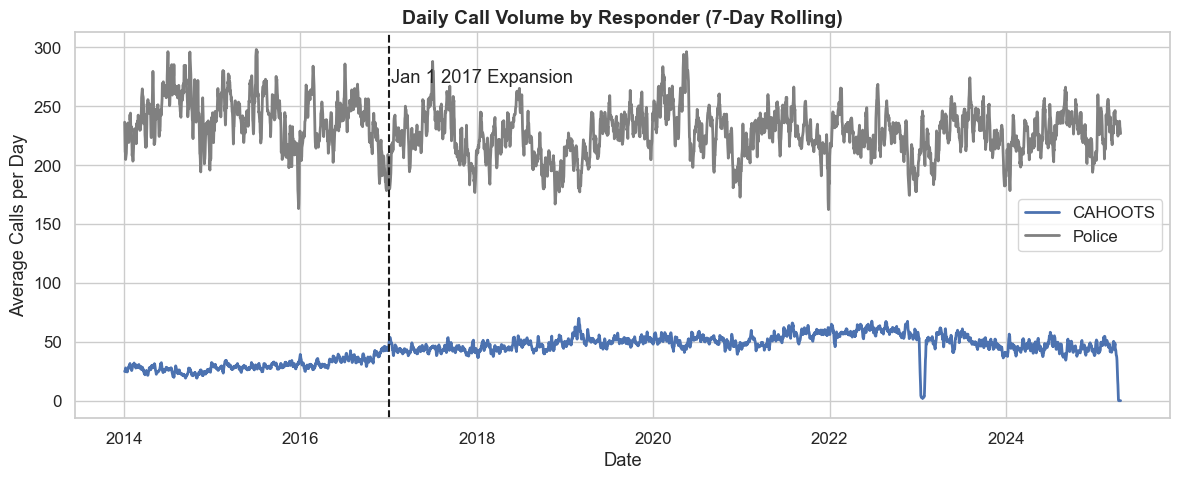

In [51]:
daily_vol = master_df.groupby(['date','Unit Type']).size().unstack(fill_value=0)

# 2. Smooth with a 7-day centered rolling average
vol_sm = daily_vol.rolling(window=7, center=True).mean()

# 3. Plot
plt.close('all')
fig, ax = plt.subplots(figsize=(12,5))
vol_sm['CAHOOTS'].plot(ax=ax, linewidth=2, label='CAHOOTS')
vol_sm['NOT CAHOOTS'].plot(ax=ax, linewidth=2, label='Police', color='gray')

# 4. Annotate expansion date
ax.axvline(EXPANSION_DATE, color='k', linestyle='--')
ymax = ax.get_ylim()[1]
ax.text(EXPANSION_DATE + pd.Timedelta(days=10), ymax*0.9,
        'Jan 1 2017 Expansion', ha='left', va='top')

# 5. Formatting
ax.set_title('Daily Call Volume by Responder (7-Day Rolling)', fontsize=14, weight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Calls per Day')
ax.legend()
plt.tight_layout()
plt.show()